# Gini Coefficient - An Intuitive Explanation

I was struggling a bit with the definition of the Scoring Metric. Googling "Gini Coefficient" gives you mostly economic explanations. Here is a descriptive explanation with regard to the challenge.

First, let's define our predictions and their actual values:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.integrate

predictions = [0.9, 0.3, 0.8, 0.75, 0.65, 0.6, 0.78, 0.7, 0.05, 0.4, 0.4, 0.05, 0.5, 0.1, 0.1]
actual = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We use the Python implementation from the [Gini coefficient discussion with code samples](https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703):

In [2]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

We calculate the Gini coefficient for the predictions:

In [3]:
gini_predictions = gini(actual, predictions)
gini_max = gini(actual, actual)
ngini= gini_normalized(actual, predictions)
print('Gini: %.3f, Max. Gini: %.3f, Normalized Gini: %.3f' % (gini_predictions, gini_max, ngini))

Gini: 0.189, Max. Gini: 0.300, Normalized Gini: 0.630


**So, how do we get this Gini of 0.189 and the Normalized Gini of 0.630?**

## Economic Explanation

The first figure on the "Gini Coefficient" Wikipedia article is this one:

<img style="float:left" height="400" width="400" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Economics_Gini_coefficient.svg/500px-Economics_Gini_coefficient.svg.png"/>
<div style="clear:both"/>

They go through the population from poorest to richest and plot the running total / cumulative share of income, which gives them the Lorenz Curve. The Gini Coefficient is then defined as the blue area divided by the area of the lower triangle.

## Application to our challenge

Instead of going through the population from poorest to richest, we go through our predictions from lowest to highest.

In [4]:
# Sort the actual values by the predictions
data = zip(actual, predictions)
sorted_data = sorted(data, key=lambda d: d[1])
sorted_actual = [d[0] for d in sorted_data]
print('Sorted Actual Values', sorted_actual)


Sorted Actual Values [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1]


Instead of summing up the income, we sum up the actual values of our predictions:

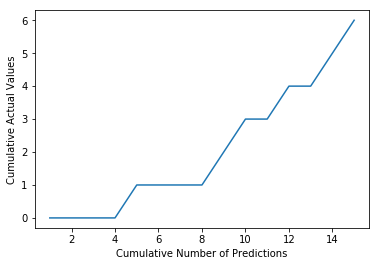

In [5]:
# Sum up the actual values
cumulative_actual = np.cumsum(sorted_actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1)

plt.plot(cumulative_index, cumulative_actual)
plt.xlabel('Cumulative Number of Predictions')
plt.ylabel('Cumulative Actual Values')
plt.show()

This corresponds to the Lorenz Curve in the diagram above.

We normalize both axes so that they go from 0 to 100% like in the economic figure and display the 45° line for illustrating random guessing:

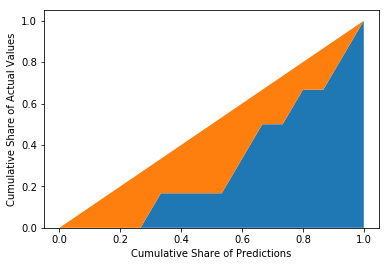

In [6]:
cumulative_actual_shares = cumulative_actual / sum(actual)
cumulative_index_shares = cumulative_index / len(predictions)

# Add (0, 0) to the plot
x_values = [0] + list(cumulative_index_shares)
y_values = [0] + list(cumulative_actual_shares)

# Display the 45° line stacked on top of the y values
diagonal = [x - y for (x, y) in zip(x_values, y_values)]

plt.stackplot(x_values, y_values, diagonal)
plt.xlabel('Cumulative Share of Predictions')
plt.ylabel('Cumulative Share of Actual Values')
plt.show()


Now, we calculate the orange area by integrating the curve function:

In [7]:
fy = scipy.interpolate.interp1d(x_values, y_values)
blue_area, _ = scipy.integrate.quad(fy, 0, 1, points=x_values)
orange_area = 0.5 - blue_area
print('Orange Area: %.3f' % orange_area)

Orange Area: 0.189


So, the orange area is equal to the Gini Coefficient calcualted above with the `gini` function. We can do the same using the actual values as predictions to get the maximum possible Gini Coefficient.

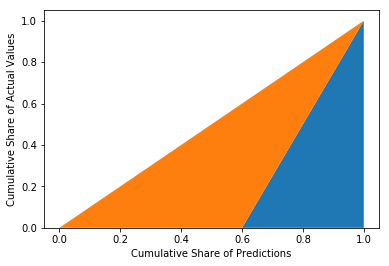

Orange Area: 0.300


In [8]:
cumulative_actual_shares_perfect = np.cumsum(sorted(actual)) / sum(actual)
y_values_perfect = [0] + list(cumulative_actual_shares_perfect)

# Display the 45° line stacked on top of the y values
diagonal = [x - y for (x, y) in zip(x_values, y_values_perfect)]

plt.stackplot(x_values, y_values_perfect, diagonal)
plt.xlabel('Cumulative Share of Predictions')
plt.ylabel('Cumulative Share of Actual Values')
plt.show()

# Integrate the the curve function
fy = scipy.interpolate.interp1d(x_values, y_values_perfect)
blue_area, _ = scipy.integrate.quad(fy, 0, 1, points=x_values)
orange_area = 0.5 - blue_area
print('Orange Area: %.3f' % orange_area)

Dividing both orange areas gives us the Normalized Gini Coefficient: 

0.189 / 0.3 = 0.630

## Alternative explanation

I also found another interpreation of the Gini Coefficient [here](http://www.rhinorisk.com/Publications/Gini%20Coefficients.pdf). Again, we take the predictions and actual values from above and sort them in descending order:

In [9]:
print("Predictions", predictions)
print("Actual Values", actual)
print("Sorted Actual", list(reversed(sorted_actual)))

Predictions [0.9, 0.3, 0.8, 0.75, 0.65, 0.6, 0.78, 0.7, 0.05, 0.4, 0.4, 0.05, 0.5, 0.1, 0.1]
Actual Values [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sorted Actual [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]


Now, we count the number of swaps of adjacent digits (like in bubble sort) it would take to get from the "Sorted Actual" state to the "Actual Values" state. In this scenario, it would take 10 swaps.

We also calculate the number of swaps it would take on average to get from a random state to the "Actual Values" state. With 6 ones and 9 zeros this results in 

$$\frac{6 \cdot 9}{2} = 27$$ swaps.

The Normalized Gini-Coefficient is how far away our sorted actual values are from a random state measured in number of swaps:

$$NGini = \frac{swaps_{random} - swaps_{sorted}}{swaps_{random}} = \frac{27 - 10}{27} = 63\%$$


I hope I could give you a better feeling for the Gini coefficient.